<a href="https://colab.research.google.com/github/andres52-code/Entregas/blob/main/Energ%C3%ADa_panelS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ingrese la latitud (°, positivo norte, negativo sur): 6.24
ingrese la longitud (°, positivo este, negativo oeste): -75.58
ingrese la fecha (YYYY-MM-DD): 2025-09-03
ingrese la zona horaria en horas respecto a UTC (-5 para Colombia): -5
ingrese la inclinacion del panel (°): 20
ingrese la orientación del panel (0=norte, 90=este, 180=sur, 270=oeste): 180
ingrese el área del panel (m²): 2
ingrese la eficiencia del panel ( 0.18 para 18%): 0.18

Energía diaria estimada: 1.87 kWh

     hora  altura solar (°)  irradiancia panel (W/m2)  potencia (kW)  \
0   01:00            -70.48                       0.0          0.000   
1   01:10            -68.57                       0.0          0.000   
2   01:20            -66.56                       0.0          0.000   
3   01:30            -64.46                       0.0          0.000   
4   01:40            -62.29                       0.0          0.000   
..    ...               ...                       ...            ...   
68  12:20         

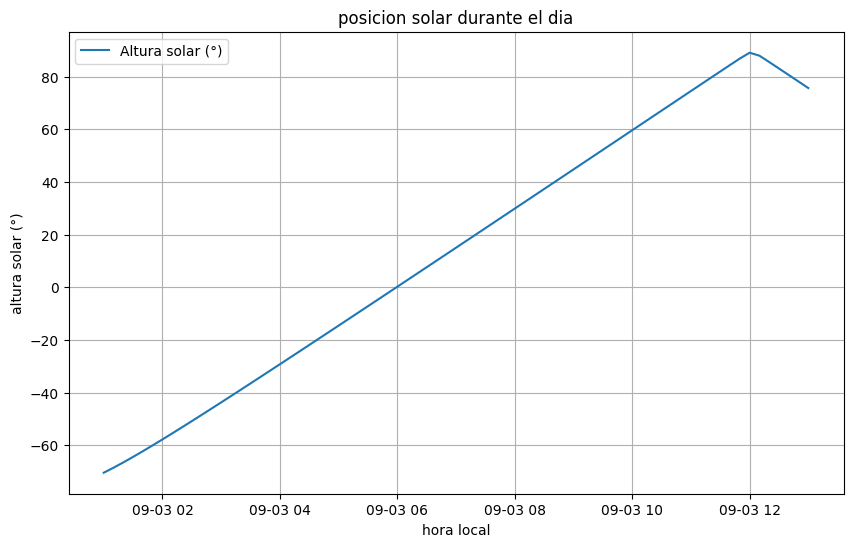

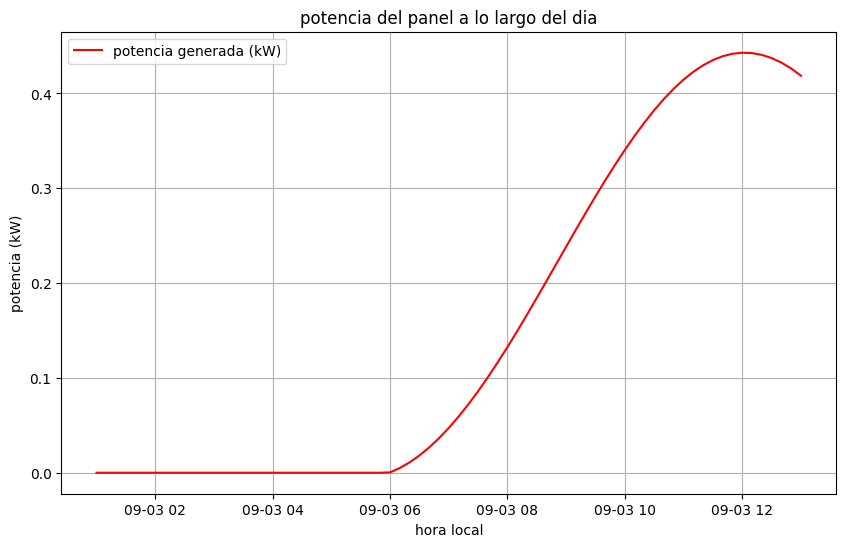

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# parametros entrada
lat = float(input("ingrese la latitud (°, positivo norte, negativo sur): "))
lon = float(input("ingrese la longitud (°, positivo este, negativo oeste): "))
fecha = input("ingrese la fecha (YYYY-MM-DD): ")
tz_offset = int(input("ingrese la zona horaria en horas respecto a UTC (-5 para Colombia): "))
tilt_deg = float(input("ingrese la inclinacion del panel (°): "))
azimuth_deg = float(input("ingrese la orientación del panel (0=norte, 90=este, 180=sur, 270=oeste): "))
panel_area = float(input("ingrese el área del panel (m²): "))
panel_efficiency = float(input("ingrese la eficiencia del panel ( 0.18 para 18%): "))

#Convertir a radianes para calculos con sen y cos
latitude = np.radians(lat)
tilt = np.radians(tilt_deg)
azimuth_panel = np.radians(azimuth_deg)
# parametros entrada

#latitude = np.radians(6.24)
#longitude = -75.58
#tz_offset = -5  # colombia  = UTC-5
#date = "2025-03-21"
#tilt = np.radians(20)   # angulo  panel
#azimuth_panel = np.radians(180)  # sur
#panel_area = 1.6  # m²
#panel_efficiency = 0.18

# tiempo
times = pd.date_range(start=fecha+" 06:00:00",
                      end=fecha+" 18:00:00",
                      freq="10min", tz="UTC")
times_local = times.tz_convert("Etc/GMT+5")

#posicion  solar
def posicionsol(lat, lon, times, tz_offset):
    n = times.dayofyear.values
    decl = np.radians(23.45) * np.sin(np.radians(360/365 * (n+284)))

    hours = times.hour.values + times.minute.values/60
    solar_time = hours + (lon/15) - tz_offset
    hour_angle = np.radians(15*(solar_time-12))

    altitude = np.arcsin(np.sin(lat)*np.sin(decl) +
                         np.cos(lat)*np.cos(decl)*np.cos(hour_angle))

    azimuth = np.arccos((np.sin(decl) - np.sin(altitude)*np.sin(lat)) /
                        (np.cos(altitude)*np.cos(lat)))
    azimuth = np.where(hour_angle > 0, 2*np.pi - azimuth, azimuth)

    return altitude, azimuth

altitude, azimuth = posicionsol(latitude, lon, times_local, tz_offset)

# 4. modelo de irradiacion
I0 = 1000  # W/m2 irradiancia maxima simplificada

dni = I0 * np.maximum(0, np.sin(altitude))   # directa
dhi = 0.3 * dni                             # difusa

cos_incidence = (np.sin(altitude)*np.cos(tilt) +
                 np.cos(altitude)*np.sin(tilt)*np.cos(azimuth - azimuth_panel))
cos_incidence = np.maximum(0, cos_incidence)

poa_global = dni * cos_incidence + dhi * np.cos(tilt/2)

# energia del panel
power_output = poa_global * panel_area * panel_efficiency / 1000  # kW
energy_step = power_output * (10/60)  # kWh cada paso de 10min
energy_cumulative = np.cumsum(energy_step)

energy_daily = energy_cumulative[-1]
print(f"\nEnergía diaria estimada: {energy_daily:.2f} kWh\n")

#algunos datos importantes
df = pd.DataFrame({
    "hora": times_local.strftime("%H:%M"),
    "altura solar (°)": np.degrees(altitude).round(2),
    "irradiancia panel (W/m2)": poa_global.round(1),
    "potencia (kW)": power_output.round(3),
    "Energía acumulada (kWh)": energy_cumulative.round(3)
})

print(df.head(100))
print("\n... (tabla completa disponible en df)\n")


# graficas

plt.figure(figsize=(10,6))
plt.plot(times_local, np.degrees(altitude), label="Altura solar (°)")
plt.ylabel("altura solar (°)")
plt.xlabel("hora local")
plt.title("posicion solar durante el dia")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(times_local, power_output, color="red", label="potencia generada (kW)")
plt.ylabel("potencia (kW)")
plt.xlabel("hora local")
plt.title("potencia del panel a lo largo del dia")
plt.legend()
plt.grid()
plt.show()